In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from collections import Counter
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import Dense
import warnings
import tensorflow as tf
import pickle
import joblib
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/boursorama.csv', delimiter=';', index_col=False)
df = df.drop_duplicates(subset=df.columns)
df = df.replace({0.0 : np.nan})
df.shape

(672, 10)

In [3]:
df.head()

,sct,year,capitaux_propres,passifs_non_courant,total_bilan,stock,creance_client,actif_immobilier,resultat_net,chiffre_d_affaires
0,AB SCIENCE,12.17,10735.0,20381.0,50600.0,159.0,449.0,1910.0,-27122.0,1739.0
1,AB SCIENCE,12.18,-14962.0,17535.0,22491.0,153.0,236.0,1725.0,-26061.0,1701.0
2,AB SCIENCE,12.19,-26829.0,24226.0,17740.0,230.0,197.0,1610.0,-21747.0,1571.0
3,ABC ARBITRAGE,12.17,148867.0,NaN,153935.0,159.0,7217.0,1386.0,18309.0,NaN
4,ABC ARBITRAGE,12.18,146291.0,NaN,151983.0,153.0,8169.0,1161.0,19679.0,NaN


In [4]:
columns_with_nan = []
for column in df.columns:
    if df[column].isnull().values.any():
        columns_with_nan.append(column)
for column in columns_with_nan:
    df[column] = df.groupby('sct')[column].transform(lambda x: x.fillna(x.mean()))

In [5]:
df.isnull().sum().sum()

87

In [6]:
df.dropna(inplace=True)
df.shape

(594, 10)

In [7]:
X = df.copy()
X['actif_courant'] = X['total_bilan'] - X['actif_immobilier']
X['passifs_courant'] = X['total_bilan'] - X['passifs_non_courant']
X['fonds_de_roulement'] = (X['capitaux_propres'] + X['passifs_non_courant'] ) - X['actif_immobilier']
X['besoin_en_fonds_de_roulement'] = (X['stock'] + X['creance_client']) - X['passifs_courant']
X['tresorie'] = X['fonds_de_roulement'] - X['besoin_en_fonds_de_roulement']
X['return_on_equity'] = X['resultat_net'] / X['capitaux_propres']
X['ratio_endettement'] = (X['total_bilan'] - X['capitaux_propres']) / X['total_bilan']
X['ratio_d_independance'] = X['capitaux_propres'] / X['passifs_non_courant']
X['ratio_de_couverture_des_emplois_stables'] = X['passifs_non_courant'] / X['actif_immobilier']
X['ratio_de_liquidite'] = X['actif_courant'] / X['passifs_courant']
X['taux_de_rentabilite'] = X['resultat_net'] / X['chiffre_d_affaires']
X['score'] = (X['tresorie'] * X['taux_de_rentabilite']) /X['ratio_endettement'] + X['passifs_courant']
scaled_score = []
for i in X['score']:
    if i >= X.score.mean():
        scaled_score.append(1)
    else:
        scaled_score.append(0)
X['score'] = scaled_score

In [8]:
y = X['score']
X.drop(axis=1, columns='score', inplace=True)

scaling data

In [9]:
x_cols = [c for c in X.columns if c != 'sct' and c != 'year']

In [10]:
x_cols

['capitaux_propres',
 'passifs_non_courant',
 'total_bilan',
 'stock',
 'creance_client',
 'actif_immobilier',
 'resultat_net',
 'chiffre_d_affaires',
 'actif_courant',
 'passifs_courant',
 'fonds_de_roulement',
 'besoin_en_fonds_de_roulement',
 'tresorie',
 'return_on_equity',
 'ratio_endettement',
 'ratio_d_independance',
 'ratio_de_couverture_des_emplois_stables',
 'ratio_de_liquidite',
 'taux_de_rentabilite']

In [11]:
def get_score(model, X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train)
    return model.score(X_test,y_test)

In [12]:
pipeline_s_lr = Pipeline([
    ('standard',StandardScaler()),
    ('lr_classifier',LogisticRegression())])

pipeline_s_svm = Pipeline([
    ('standard',StandardScaler()),
    ('svc',SVC())])

pipeline_s_xgb = Pipeline([
    ('standard',StandardScaler()),
    ('xgb',XGBClassifier())
    ])

pipeline_mm_lr = Pipeline([
    ('minmax',StandardScaler()),
    ('lr_classifier',LogisticRegression())])

pipeline_mm_svm = Pipeline([
    ('minmax',StandardScaler()),
    ('svc',SVC())])

pipeline_mm_xgb = Pipeline([
    ('minmax',StandardScaler()),
    ('xgb',XGBClassifier())
    ])

In [13]:
folds = StratifiedKFold(n_splits=10)
scores_s_lr = []
scores_s_svm = []
scores_s_xgb = []
scores_mm_lr = []
scores_mm_svm = []
scores_mm_xgb = []
for train_index, test_index in folds.split(X[x_cols],y):
    X_train, X_test, y_train, y_test = X[x_cols].to_numpy()[train_index], X[x_cols].to_numpy()[test_index], y.to_numpy()[train_index], y.to_numpy()[test_index]     
    scores_s_lr.append(get_score(pipeline_s_lr, X_train, X_test, y_train, y_test))
    scores_s_svm.append(get_score(pipeline_s_svm, X_train, X_test, y_train, y_test))
    scores_s_xgb.append(get_score(pipeline_s_xgb, X_train, X_test, y_train, y_test))
    scores_mm_lr.append(get_score(pipeline_mm_lr, X_train, X_test, y_train, y_test))
    scores_mm_svm.append(get_score(pipeline_mm_svm, X_train, X_test, y_train, y_test))
    scores_mm_xgb.append(get_score(pipeline_mm_xgb, X_train, X_test, y_train, y_test))

[02:33:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:33:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:33:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:33:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [14]:
print('Logistic regression standard scaler Score \t: ', sum(scores_s_lr)/len(scores_s_lr))
print('SVM Score standard scaler \t\t\t: ', sum(scores_s_svm)/len(scores_s_svm))
print('XGB Score standard scaler \t\t\t: ', sum(scores_s_xgb)/len(scores_s_xgb))
print('Logistic regression mm scaler Score \t: ', sum(scores_mm_lr)/len(scores_mm_lr))
print('SVM mm scaler Score \t\t\t: ', sum(scores_mm_svm)/len(scores_mm_svm))
print('XGB mm scaler Score \t\t\t: ', sum(scores_mm_xgb)/len(scores_mm_xgb))

Logistic regression standard scaler Score 	:  0.9933333333333334
SVM Score standard scaler 			:  0.991638418079096
XGB Score standard scaler 			:  0.9966666666666667
Logistic regression mm scaler Score 	:  0.9933333333333334
SVM mm scaler Score 			:  0.991638418079096
XGB mm scaler Score 			:  0.9966666666666667


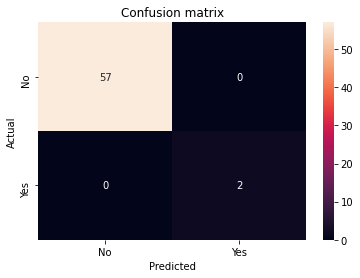

In [15]:
y_pred = pipeline_s_xgb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion matrix')
ax.xaxis.set_ticklabels(["No","Yes"])
ax.yaxis.set_ticklabels(["No","Yes"])
plt.show()

In [16]:
filename = 'loan_model_lr.pkl'
joblib.dump(pipeline_s_lr, filename)

['loan_model_lr.pkl']